In [1]:
import os

# Set environment variables
# OPENAI_API_KEYとLANGCHAIN_API_KEYは.envから読み込む
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = "ai-agent-tutorial"

In [2]:
import operator
from typing import Annotated, Any
from langchain_core.messages import SystemMessage, HumanMessage, BaseMessage
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

# グラフのステートを定義
class State(BaseModel):
    query: str
    messages: Annotated[list[BaseMessage], operator.add] = Field(default=[])

# メッセージを追加するノード関数
def add_message(state: State) -> dict[str, Any]:
    additional_messages = []
    if not state.messages:
        additional_messages.append(
            SystemMessage(content="あなたは最小限の応答をする対話エージェントです。")
        )
    additional_messages.append(HumanMessage(content=state.query))
    return {"messages": additional_messages}

# LLMからの応答を追加するノード関数
def llm_response(state: State) -> dict[str, Any]:
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)
    ai_message = llm.invoke(state.messages)
    return {"messages": [ai_message]}

In [3]:
from pprint import pprint
from langchain_core.runnables import RunnableConfig
from langgraph.checkpoint.base import BaseCheckpointSaver

def print_checkpoint_dump(checkpointer: BaseCheckpointSaver, config: RunnableConfig):
    checkpoint_tuple = checkpointer.get_tuple(config)

    print("チェックポイントデータ:")
    pprint(checkpoint_tuple.checkpoint)
    print("\nメタデータ:")
    pprint(checkpoint_tuple.metadata)

In [4]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

# グラフを設定
graph = StateGraph(State)
graph.add_node("add_message", add_message)
graph.add_node("llm_response", llm_response)

graph.set_entry_point("add_message")
graph.add_edge("add_message", "llm_response")
graph.add_edge("llm_response", END)

# チェックポインターを設定
checkpointer = MemorySaver()

# グラフをコンパイル
compiled_graph = graph.compile(checkpointer=checkpointer)

In [5]:
config = {"configurable": {"thread_id": "example-1"}}
user_query = State(query="私の好きなものはずんだ餅です。覚えておいてね。")
first_response = compiled_graph.invoke(user_query, config)
first_response

{'query': '私の好きなものはずんだ餅です。覚えておいてね。',
 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
  AIMessage(content='了解しました！ずんだ餅が好きなんですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 48, 'total_tokens': 61, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BdbuEjmKl1aIgh5SMHLpLy8dpcLsl', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--96a219b0-f606-40ea-8e32-9ebe84024cc5-0', usage_metadata={'input_tokens': 48, 'output_tokens': 13, 'total_tokens': 61, 'input_token_details': {'audio': 0, 'cache_rea

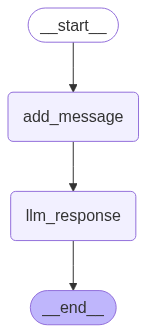

In [6]:
compiled_graph

In [7]:
for checkpoint in checkpointer.list(config):
    print(checkpoint)

CheckpointTuple(config={'configurable': {'thread_id': 'example-1', 'checkpoint_ns': '', 'checkpoint_id': '1f03ee24-76b7-6e02-8002-00911b525c36'}}, checkpoint={'v': 3, 'ts': '2025-06-01T12:16:43.024318+00:00', 'id': '1f03ee24-76b7-6e02-8002-00911b525c36', 'channel_versions': {'__start__': '00000000000000000000000000000002.0.9467257644853683', 'query': '00000000000000000000000000000002.0.31838244744012645', 'messages': '00000000000000000000000000000004.0.027261979950105375', 'branch:to:add_message': '00000000000000000000000000000003.0.8097016081676595', 'branch:to:llm_response': '00000000000000000000000000000004.0.8892483771467122'}, 'versions_seen': {'__input__': {}, '__start__': {'__start__': '00000000000000000000000000000001.0.04780346068309549'}, 'add_message': {'branch:to:add_message': '00000000000000000000000000000002.0.27915660035960255'}, 'llm_response': {'branch:to:llm_response': '00000000000000000000000000000003.0.6816321670800136'}}, 'channel_values': {'query': '私の好きなものはずんだ餅です

In [8]:
print_checkpoint_dump(checkpointer, config)

チェックポイントデータ:
{'channel_values': {'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
                                 HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
                                 AIMessage(content='了解しました！ずんだ餅が好きなんですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 48, 'total_tokens': 61, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BdbuEjmKl1aIgh5SMHLpLy8dpcLsl', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--96a219b0-f606-40ea-8e32-9ebe84024cc5-0', usage_metadata={'input_tokens': 48, 'output_tokens': 13, 'total_to

In [9]:
user_query = State(query="私の好物は何か覚えてる？")
second_response = compiled_graph.invoke(user_query, config)
second_response

{'query': '私の好物は何か覚えてる？',
 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
  AIMessage(content='了解しました！ずんだ餅が好きなんですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 48, 'total_tokens': 61, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BdbuEjmKl1aIgh5SMHLpLy8dpcLsl', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--96a219b0-f606-40ea-8e32-9ebe84024cc5-0', usage_metadata={'input_tokens': 48, 'output_tokens': 13, 'total_tokens': 61, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'ou

In [11]:
user_query = State(query="私の名前は何？")
second_response = compiled_graph.invoke(user_query, config)
second_response

{'query': '私の名前は何？',
 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
  AIMessage(content='了解しました！ずんだ餅が好きなんですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 48, 'total_tokens': 61, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BdbuEjmKl1aIgh5SMHLpLy8dpcLsl', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--96a219b0-f606-40ea-8e32-9ebe84024cc5-0', usage_metadata={'input_tokens': 48, 'output_tokens': 13, 'total_tokens': 61, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_

In [12]:
for checkpoint in checkpointer.list(config):
    print(checkpoint)

CheckpointTuple(config={'configurable': {'thread_id': 'example-1', 'checkpoint_ns': '', 'checkpoint_id': '1f040777-ae1d-6d08-800e-05baa034d5f2'}}, checkpoint={'v': 3, 'ts': '2025-06-03T12:37:15.539367+00:00', 'id': '1f040777-ae1d-6d08-800e-05baa034d5f2', 'channel_versions': {'__start__': '00000000000000000000000000000014.0.499428735843902', 'query': '00000000000000000000000000000014.0.20647831577417775', 'messages': '00000000000000000000000000000016.0.3447384876145323', 'branch:to:add_message': '00000000000000000000000000000015.0.27430894014383034', 'branch:to:llm_response': '00000000000000000000000000000016.0.8089748564961544'}, 'versions_seen': {'__input__': {}, '__start__': {'__start__': '00000000000000000000000000000013.0.7071747474140072'}, 'add_message': {'branch:to:add_message': '00000000000000000000000000000014.0.6502330745015187'}, 'llm_response': {'branch:to:llm_response': '00000000000000000000000000000015.0.8605514270879149'}}, 'channel_values': {'query': '私の名前は何？', 'message

In [13]:
print_checkpoint_dump(checkpointer, config)

チェックポイントデータ:
{'channel_values': {'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
                                 HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
                                 AIMessage(content='了解しました！ずんだ餅が好きなんですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 48, 'total_tokens': 61, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BdbuEjmKl1aIgh5SMHLpLy8dpcLsl', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--96a219b0-f606-40ea-8e32-9ebe84024cc5-0', usage_metadata={'input_tokens': 48, 'output_tokens': 13, 'total_to

In [14]:
config = {"configurable": {"thread_id": "example-2"}}
user_query = State(query="私の好物は何？")
other_thread_response = compiled_graph.invoke(user_query, config)
other_thread_response

{'query': '私の好物は何？',
 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私の好物は何？', additional_kwargs={}, response_metadata={}),
  AIMessage(content='わかりません。あなたの好物は何ですか？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 36, 'total_tokens': 50, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BeLBx3DeDZJjsjtCqF1VGPQ7q2E0h', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--3b2c3c10-5dd4-4b0e-b596-cd2c4c08e7fb-0', usage_metadata={'input_tokens': 36, 'output_tokens': 14, 'total_tokens': 50, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {